In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pathlib 
import os
import joblib

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from collections import Counter
from datetime import date 
import datetime


In [45]:
cur_path  = os.getcwd()

devices_df = pd.read_csv(cur_path + '/devices.csv')
readings_df = pd.read_csv(cur_path + '/sampled_readings.csv')
reading_types_df = pd.read_csv(cur_path + '/reading_types.csv')

### Outlier Detection Using IQR

In [46]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.nanpercentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.nanpercentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        print("First Quartertile:", Q1, ". Third Quartile: ", Q3, ".Interquartile Range: ", IQR)
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= n )
    
    return multiple_outliers   

In [47]:
processed_df = readings_df 
for k, v in readings_df.groupby('value_type_id'):
    print(reading_types_df.at[k - 1, 'reading_type_name'],'-'*90)
    outliers = detect_outliers(v, 1, ['value'])
    processed_df = processed_df.drop(outliers, axis = 0) 

processed_df.info()

CO2 ------------------------------------------------------------------------------------------
First Quartertile: 429.0 . Third Quartile:  565.1 .Interquartile Range:  136.10000000000002
CO ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  1.7 .Interquartile Range:  1.7
TVOC ------------------------------------------------------------------------------------------
First Quartertile: 31.0 . Third Quartile:  248.0 .Interquartile Range:  217.0
PM10 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.0 .Interquartile Range:  0.0
PM25 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.2 .Interquartile Range:  0.2
PM01 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartil

### Merging devices with sampled readings

In [48]:
#merging devices with sampleled readings

merged_df = pd.merge(processed_df, devices_df, on='device_id', how='inner')
merged_df = merged_df.drop('device_id', axis = 1)

### Have aggregate value_types with the same hour

In [49]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = merged_df['date'].dt.floor('H')

aggregate_function = {'value': 'mean'}
aggregate_df = merged_df.groupby(['building_id', 'date', 'value_type_id']).agg(aggregate_function)


#pivot table so that value_type_id is a column 
# pivot_df = pd.pivot_table(aggregate_df, values = 'value', index = ['date', 'building_id'], columns = 'value_type_id').reset_index()  
# pivot_df = pivot_df.rename_axis(None).rename_axis(None, axis=1)
# pivot_df.info()

### Downsampling readings to hour

In [50]:
pivot_df = aggregate_df.sort_values(by = 'date')

resampled_df = pivot_df

# def my_interp(x):
#     if x.notnull().sum() > 1:
#         return x.interpolate(method='nearest').ffill().bfill()
#     else:
#         return x.ffill().bfill()
    
# for building, df in pivot_df.groupby('building_id'):
#     df = df.sort_values(by = 'date')
#     # resampled = df.resample('60min', on = 'date', label = 'left').mean() 
#     # resampled ['date'] = resampled.index.values
#     resampled = df.interpolate(method='linear', axis=0).ffill().bfill()
#     resampled_df = pd.concat([resampled_df, resampled], ignore_index = True)

resampled_df.info()
print(resampled_df.head(100))
resampled_df = resampled_df.sort_values(by = 'date')
# resampled_df.to_csv('googoogagag.csv')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 530498 entries, (1, Timestamp('2023-01-01 00:00:00'), 3) to (41, Timestamp('2023-12-31 23:00:00'), 4)
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   530498 non-null  float64
dtypes: float64(1)
memory usage: 6.1 MB
                                                 value
building_id date                value_type_id         
1           2023-01-01 00:00:00 3              194.000
32          2023-01-01 00:00:00 7                5.900
31          2023-01-01 00:00:00 4                0.000
2           2023-01-01 00:00:00 5                0.200
                                12              33.600
...                                                ...
6           2023-01-01 01:00:00 1              482.000
                                12              35.050
25          2023-01-01 01:00:00 9               18.900
                                7                7.900
  

In [51]:
# hour_mapping (1 if between 8am and 6pm)

# readings_df['date'] = pd.to_datetime(readings_df['date'])

resampled_df['work_hours'] = resampled_df['date'].dt.hour.between(8, 18)
resampled_df['work_hours'].map({True: 1, False: 0})


0          1
1          1
2          0
3          1
4          1
          ..
1048570    0
1048571    1
1048572    1
1048573    1
1048574    0
Name: work_hours, Length: 1048575, dtype: int64

In [52]:
# day of week mapping (1 weekday, 0 weekend)

resampled_df['day type'] = resampled_df['date'].dt.dayofweek.map({
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 0, 
    6: 0
})

resampled_df.info()

KeyError: 'date'

In [ ]:
# season mapping

resampled_df['season'] = resampled_df['date'].dt.month.map({
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
})

season_encoder = pd.get_dummies(resampled_df['season'])
resampled_df = resampled_df.join(season_encoder)
resampled_df = resampled_df.drop('season', axis = 1)

In [ ]:
def get_trimester_day(row): 
    dt = (row['date']).date()
    if 3 <= dt.month <= 5:
        return (dt - date(year=dt.year, month=3, day=1)) # Spring
    elif 6 <= dt.month <= 8:
        return (dt - date(year=dt.year, month=6, day=1))  # Summer
    elif 9 <= dt.month <= 11:
        return (dt - date(year=dt.year, month=9, day=1))  # Autumn
    else:
        if(dt.month == 12): 
            return (dt - date(year=dt.year, month=12, day=1))
        return (dt - date(year=dt.year - 1, month=12, day=1))  # Winter
    
resampled_df['trimester_day'] = resampled_df.apply(get_trimester_day, axis = 1)
resampled_df['trimester_day'] = resampled_df['trimester_day'].dt.days


In [ ]:
def get_working_hour(row): 
    dt = (row['date']) 
    return dt.hour - 8

resampled_df['working_hour'] = resampled_df.apply(get_working_hour, axis = 1)
resampled_df = resampled_df.fillna(0)
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124278 entries, 0 to 124277
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           124278 non-null  datetime64[ns]
 1   building_id    124278 non-null  int64         
 2   1              124278 non-null  float64       
 3   2              124278 non-null  float64       
 4   3              124278 non-null  float64       
 5   4              124278 non-null  float64       
 6   5              124278 non-null  float64       
 7   6              124278 non-null  float64       
 8   7              124278 non-null  float64       
 9   8              124278 non-null  float64       
 10  9              124278 non-null  float64       
 11  10             124278 non-null  float64       
 12  11             124278 non-null  float64       
 13  12             124278 non-null  float64       
 14  day type       124278 non-null  int64         
 15  Fall 

### Building Encoder

In [ ]:
# final_df = resampled_df 
# building_encoder = pd.get_dummies(final_df['building_id'], prefix  = 'building')
# final_df = final_df.join(building_encoder)
# final_df = final_df.drop('building_id', axis = 1) 

# device_encoder = pd.get_dummies(mergedDf['device_id'], prefix = 'device')
# mergedDf = mergedDf.join(device_encoder) don't know if this matters as much 

#### IMPORTANT: uncomment the line highlighted if you do not have preprocessed.csv, use this in the model.ipynb (so we stop working on same file)

In [ ]:
resampled_df.to_csv('preprocessed_lstm_unpivoted.csv') # <-- COMMENT THIS OUT IF YOU DON'T HAVE preprocessd.csv yet 

In [40]:
# seperate into RH + temp and others
df_11_12 = readings_df[readings_df['value_type_id'].isin([11, 12])]
df_other = readings_df[~readings_df['value_type_id'].isin([11, 12])]

In [41]:
#nomalize categories
# df_11_12 = pd.get_dummies(df_11_12, columns=['season'])
# df_other = pd.get_dummies(df_other, columns=['season'])

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 6 to 5044
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      409 non-null    int64         
 1   date           409 non-null    datetime64[ns]
 2   value_type_id  409 non-null    int64         
 3   value          409 non-null    float64       
 4   work_hours     409 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 16.4 KB


<function matplotlib.pyplot.show(close=None, block=None)>

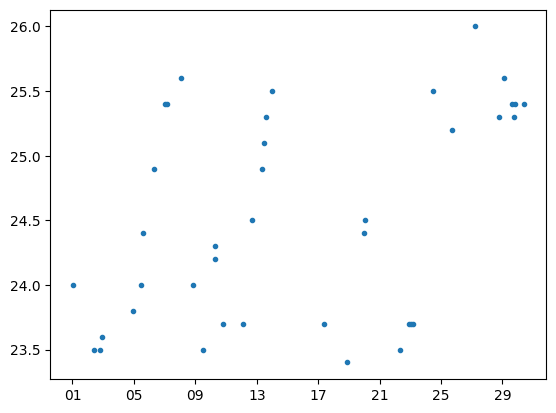

In [42]:
#to filter value_type_id and device_id
filtered_df = readings_df[(readings_df['value_type_id'] == 11) & (readings_df['device_id'] == 1)]

filtered_df.info()

start_date = '2023-8-01'
end_date = '2023-8-31'
filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]

# scatter for >1 day
plt.scatter(filtered_df['date'], filtered_df['value'], marker='.')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))


# scatter for <1 day
# plt.scatter(filtered_df['date'].dt.hour + filtered_df['date'].dt.minute / 60, filtered_df['value'], marker='.')


plt.show



In [43]:
# Augmented Dickey-Fuller test
# determines if a series is stationary
filtered_df.info()

test_series_data = filtered_df[['value']]
test_series_data.index = pd.to_datetime(filtered_df['date'])

results = adfuller(test_series_data)

print('Test Statistic:', results[0])
print('P-Value:', results[1])


<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 52 to 4921
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      39 non-null     int64         
 1   date           39 non-null     datetime64[ns]
 2   value_type_id  39 non-null     int64         
 3   value          39 non-null     float64       
 4   work_hours     39 non-null     bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 KB
Test Statistic: -1.2588939802727803
P-Value: 0.6477624054443933
